# Hybrid Recommender Systems

## Motivation

Previous parts showed two complementary failure modes on the Book Crossing dataset:

| Model | Strength | Weakness |
|-------|----------|----------|
| FunkSVD / ALS | Captures user taste via co-rating patterns | Fails for cold items (no history) |
| ContentBased | Works for new items via author/publisher/year | Over-specialises; misses cross-genre taste |

**Hybrid** systems combine both signals to compensate for each other's blind spots.

## Hybrid Strategies Implemented

### 1. WeightedHybrid (score-level blending)
```
score(u,i) = α · CF_score(u,i) + (1-α) · CB_score(u,i)
```
Both models score every candidate; scores are min-max normalised per model to avoid scale dominance, then blended.  
**α** is a tunable weight: `α=1.0` → pure CF, `α=0.0` → pure CB.

### 2. CascadeHybrid (candidate generation + reranking)
- **Stage 1** (generator): ContentBasedRecommender produces a large candidate pool (N=300).  
  CB recall is high even for cold items because feature vectors use only book metadata.
- **Stage 2** (ranker): FunkSVD re-scores each candidate using learned latent factors.  
  FunkSVD sharpens personalisation within the candidate pool.

## Design Justification

**Why CB as generator?**  
Books in the test period (2002-2004) were published *after* the training cut-off; they have zero co-rating history so CF has no latent factors for them. CB uses metadata alone and retrieves relevant candidates regardless of publication recency.

**Why FunkSVD as reranker?**  
Among candidates that *do* appear in training, FunkSVD applies personalised biases (`bu`, `bi`) and latent dot-products that reflect community taste patterns.

**Who benefits?**  
- *WeightedHybrid* — all users; most impactful for moderately active users (5–20 ratings) where both signals are partially reliable.
- *CascadeHybrid* — users who read newly published books (cold-item scenario). The CB generator surface candidates that pure CF would miss entirely.

## 1. Setup

In [1]:
import sys
sys.path.append('..')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from src.data.loader import load_all_data
from src.data.splitter import (
    create_temporal_split,
    SplitConfig,
    UserTemporalSplitConfig,
    add_random_timestamps,
)
from src.models import FunkSVD, FunkSVDConfig, ContentBasedRecommender
from src.models.hybrid import (
    WeightedHybrid, WeightedHybridConfig,
    CascadeHybrid, CascadeHybridConfig,
)
from src.evaluation import (
    EvaluationPipeline,
    GlobalMeanBaseline,
    UserMeanBaseline,
    PopularityBaseline,
    print_evaluation_results,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

K_VALUES   = [5, 10, 20]
pipeline   = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6.0)
all_results = {}

## 2. Data Loading and Split

We reuse the **per-user temporal split** from the matrix factorisation notebook (80 / 10 / 10 %, minimum 5 interactions per user/item).  
A random timestamp is synthesised to order each user's ratings chronologically so the split is meaningful.

In [2]:
ratings, books, users = load_all_data('../data/raw')

ratings_ts = add_random_timestamps(
    ratings, start="2004-08-01", end="2004-09-30", seed=123, ts_col="timestamp"
)

split_config = UserTemporalSplitConfig(
    train_frac=0.8,
    val_frac=0.1,
    test_frac=0.1,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions=5,
    min_item_interactions=5,
    explicit_only=True,
)

train_df, val_df, test_df, split_info = create_temporal_split(
    ratings_ts, books, "users", split_config
)

print(f"\nBooks DataFrame shape: {books.shape}")


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 134,016 ratings, 11,966 users, 10,522 items
Iteration 2: 116,166 ratings, 7,134 users, 9,145 items
Iteration 3: 114,616 ratings, 6,842 users, 9,026 items
Iteration 4: 114,430 ratings, 6,812 users, 9,006 items
Iteration 5: 114,373 ratings, 6,804 users, 8,999 items
Iteration 6: 114,354 ratings, 6,802 users, 8,996 items
Iteration 7: 114,334 ratings, 6,800 users, 8,993 items
Iteration 8: 114,326 ratings, 6,799 users, 8,992 items
Iteration 9: 114,295 ratings, 6,796 users, 8,987 items
Iteration 10: 114,279 ratings, 6,794 users, 8,985 items
Iteration 11: 114,271 ratings, 6,792 users, 8,985 items
Iteration 12: 114,271 ratings, 6,792 users, 8,985 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 85,206 ratings
  Val: 11,562 ratings
  Test: 17,503 ratings

--- Step 3: Ensuring test users have training 

In [3]:
# Analyse cold-item fraction in test set
train_items = set(train_df['isbn'].unique())
test_items  = set(test_df['isbn'].unique())
cold_items  = test_items - train_items

print(f"Train items : {len(train_items):,}")
print(f"Test items  : {len(test_items):,}")
print(f"Cold items  : {len(cold_items):,}  ({100*len(cold_items)/len(test_items):.1f}% of test items)")

cold_item_ratings = test_df[test_df['isbn'].isin(cold_items)]
print(f"Test ratings on cold items : {len(cold_item_ratings):,} "
      f"({100*len(cold_item_ratings)/len(test_df):.1f}% of test ratings)")

Train items : 8,983
Test items  : 6,647
Cold items  : 2  (0.0% of test items)
Test ratings on cold items : 5 (0.0% of test ratings)


## 3. Baseline Models

In [4]:
# ---- Global Mean ----
gm = GlobalMeanBaseline().fit(train_df)
all_results['Global Mean'] = pipeline.evaluate_rating_prediction(gm, test_df)

# ---- User Mean ----
um = UserMeanBaseline().fit(train_df)
all_results['User Mean'] = pipeline.evaluate_rating_prediction(um, test_df)

# ---- Popularity (ranking baseline) ----
pop = PopularityBaseline(by='count').fit(train_df)
pop_rating  = pipeline.evaluate_rating_prediction(pop, test_df)
pop_ranking = pipeline.evaluate_ranking(pop, test_df, train_df)
all_results['Popularity'] = {**pop_rating, **pop_ranking}

print("Baselines:")
for name in ['Global Mean', 'User Mean', 'Popularity']:
    r = all_results[name]
    ndcg = r.get('ndcg@10', float('nan'))
    print(f"  {name:<14}  RMSE={r['rmse']:.4f}  MAE={r['mae']:.4f}  NDCG@10={ndcg:.4f}")

Baselines:
  Global Mean     RMSE=1.7871  MAE=1.4116  NDCG@10=nan
  User Mean       RMSE=1.6388  MAE=1.2384  NDCG@10=nan
  Popularity      RMSE=1.7991  MAE=1.4112  NDCG@10=0.0139


## 4. Individual Sub-Models (components)

We first evaluate each sub-model independently so we can judge the hybrid's marginal contribution.

### 4.1 FunkSVD (collaborative)

In [5]:
svd_config = FunkSVDConfig(
    n_factors=50,
    n_epochs=20,
    lr=0.01,
    reg=0.02,
    seed=42,
    min_rating=1,
    max_rating=10,
    early_stopping=True,
    patience=3,
)

t0 = time.time()
svd = FunkSVD(svd_config).fit(
    train_df, val_df=val_df, verbose=True
)
print(f"FunkSVD fitted in {time.time()-t0:.1f}s")

svd_rating  = pipeline.evaluate_rating_prediction(svd, test_df)
svd_ranking = pipeline.evaluate_ranking(svd, test_df, train_df)
all_results['FunkSVD'] = {**svd_rating, **svd_ranking}

print(f"  RMSE={svd_rating['rmse']:.4f}  MAE={svd_rating['mae']:.4f}  "
      f"NDCG@10={svd_ranking.get('ndcg@10',0):.4f}  "
      f"HR@10={svd_ranking.get('hit_rate@10',0):.4f}")

Epoch 01: train RMSE=1.6210 | val RMSE=1.6681
Epoch 02: train RMSE=1.5569 | val RMSE=1.6299
Epoch 03: train RMSE=1.5161 | val RMSE=1.6082
Epoch 04: train RMSE=1.4859 | val RMSE=1.5930
Epoch 05: train RMSE=1.4623 | val RMSE=1.5818
Epoch 06: train RMSE=1.4432 | val RMSE=1.5740
Epoch 07: train RMSE=1.4264 | val RMSE=1.5681
Epoch 08: train RMSE=1.4106 | val RMSE=1.5635
Epoch 09: train RMSE=1.3934 | val RMSE=1.5611
Epoch 10: train RMSE=1.3756 | val RMSE=1.5578
Epoch 11: train RMSE=1.3610 | val RMSE=1.5560
Epoch 12: train RMSE=1.3500 | val RMSE=1.5553
Epoch 13: train RMSE=1.3399 | val RMSE=1.5538
Epoch 14: train RMSE=1.3297 | val RMSE=1.5533
Epoch 15: train RMSE=1.3190 | val RMSE=1.5529
Epoch 16: train RMSE=1.3077 | val RMSE=1.5528
Epoch 17: train RMSE=1.2956 | val RMSE=1.5532
Epoch 18: train RMSE=1.2823 | val RMSE=1.5536
Early stopping at epoch 18 (best val RMSE=1.5529)
FunkSVD fitted in 7.8s


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: divide by zero encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: overflow encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: invalid value encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)


  RMSE=1.5581  MAE=1.1904  NDCG@10=0.0006  HR@10=0.0033


### 4.2 Content-Based Recommender

In [6]:
t0 = time.time()
cb = ContentBasedRecommender(
    books_df=books,
    similarity_metric='cosine',
    n_neighbors=50,
    relevance_threshold=6.0,
).fit(train_df)
print(f"ContentBased fitted in {time.time()-t0:.1f}s")

cb_rating  = pipeline.evaluate_rating_prediction(cb, test_df)
cb_ranking = pipeline.evaluate_ranking(cb, test_df, train_df)
all_results['ContentBased'] = {**cb_rating, **cb_ranking}

print(f"  RMSE={cb_rating['rmse']:.4f}  MAE={cb_rating['mae']:.4f}  "
      f"NDCG@10={cb_ranking.get('ndcg@10',0):.4f}  "
      f"HR@10={cb_ranking.get('hit_rate@10',0):.4f}")

/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


ContentBased fitted in 3.0s
  RMSE=1.6205  MAE=1.2176  NDCG@10=0.0148  HR@10=0.0416


## 5. Hybrid Models

### 5.1 WeightedHybrid (α = 0.6)

In [7]:
wh_config = WeightedHybridConfig(
    alpha=0.6,
    funksvd=FunkSVDConfig(
        n_factors=50, n_epochs=20, lr=0.01, reg=0.02, seed=42,
        min_rating=1, max_rating=10, early_stopping=True, patience=3,
    ),
    cb_similarity='cosine',
    cb_n_neighbors=50,
    cb_relevance_threshold=6.0,
    n_candidates=200,
)

t0 = time.time()
wh = WeightedHybrid(books_df=books, config=wh_config).fit(
    train_df, val_df=val_df, verbose=True
)
print(f"WeightedHybrid fitted in {time.time()-t0:.1f}s")

Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
Epoch 01: train RMSE=1.6210 | val RMSE=1.6681
Epoch 02: train RMSE=1.5569 | val RMSE=1.6299
Epoch 03: train RMSE=1.5161 | val RMSE=1.6082
Epoch 04: train RMSE=1.4859 | val RMSE=1.5930
Epoch 05: train RMSE=1.4623 | val RMSE=1.5818
Epoch 06: train RMSE=1.4432 | val RMSE=1.5740
Epoch 07: train RMSE=1.4264 | val RMSE=1.5681
Epoch 08: train RMSE=1.4106 | val RMSE=1.5635
Epoch 09: train RMSE=1.3934 | val RMSE=1.5611
Epoch 10: train RMSE=1.3756 | val RMSE=1.5578
Epoch 11: train RMSE=1.3610 | val RMSE=1.5560
Epoch 12: train RMSE=1.3500 | val RMSE=1.5553
Epoch 13: train RMSE=1.3399 | val RMSE=1.5538
Epoch 14: train RMSE=1.3297 | val RMSE=1.5533
Epoch 15: train RMSE=1.3190 | val RMSE=1.5529
Epoch 16: train RMSE=1.3077 | val RMSE=1.5528
Epoch 17: train RMSE=1.2956 | val RMSE=1.5532
Epoch 18: train RMSE=1.2823 | val RMSE=1.5536
Early stopping at epoch 18 (best val RMSE=1.5529)
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
WeightedHybrid fitted in 12.1s


In [8]:
wh_rating  = pipeline.evaluate_rating_prediction(wh, test_df)
wh_ranking = pipeline.evaluate_ranking(wh, test_df, train_df)
all_results['WeightedHybrid'] = {**wh_rating, **wh_ranking}

print(f"  RMSE={wh_rating['rmse']:.4f}  MAE={wh_rating['mae']:.4f}  "
      f"NDCG@10={wh_ranking.get('ndcg@10',0):.4f}  "
      f"HR@10={wh_ranking.get('hit_rate@10',0):.4f}")

  RMSE=1.5481  MAE=1.1781  NDCG@10=0.0291  HR@10=0.0832


### 5.2 CascadeHybrid (CB generate → FunkSVD rerank)

In [9]:
ch_config = CascadeHybridConfig(
    n_candidates=300,
    funksvd=FunkSVDConfig(
        n_factors=50, n_epochs=20, lr=0.01, reg=0.02, seed=42,
        min_rating=1, max_rating=10, early_stopping=True, patience=3,
    ),
    cb_similarity='cosine',
    cb_n_neighbors=50,
    cb_relevance_threshold=6.0,
)

t0 = time.time()
ch = CascadeHybrid(books_df=books, config=ch_config).fit(
    train_df, val_df=val_df, verbose=True
)
print(f"CascadeHybrid fitted in {time.time()-t0:.1f}s")

Fitting CascadeHybrid...
  [1/2] Fitting ContentBased (Stage 1 — generator)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [2/2] Fitting FunkSVD (Stage 2 — ranker)...
Epoch 01: train RMSE=1.6210 | val RMSE=1.6681
Epoch 02: train RMSE=1.5569 | val RMSE=1.6299
Epoch 03: train RMSE=1.5161 | val RMSE=1.6082
Epoch 04: train RMSE=1.4859 | val RMSE=1.5930
Epoch 05: train RMSE=1.4623 | val RMSE=1.5818
Epoch 06: train RMSE=1.4432 | val RMSE=1.5740
Epoch 07: train RMSE=1.4264 | val RMSE=1.5681
Epoch 08: train RMSE=1.4106 | val RMSE=1.5635
Epoch 09: train RMSE=1.3934 | val RMSE=1.5611
Epoch 10: train RMSE=1.3756 | val RMSE=1.5578
Epoch 11: train RMSE=1.3610 | val RMSE=1.5560
Epoch 12: train RMSE=1.3500 | val RMSE=1.5553
Epoch 13: train RMSE=1.3399 | val RMSE=1.5538
Epoch 14: train RMSE=1.3297 | val RMSE=1.5533
Epoch 15: train RMSE=1.3190 | val RMSE=1.5529
Epoch 16: train RMSE=1.3077 | val RMSE=1.5528
Epoch 17: train RMSE=1.2956 | val RMSE=1.5532
Epoch 18: train RMSE=1.2823 | val RMSE=1.5536
Early stopping at epoch 18 (best val RMSE=1.5529)
  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Us

/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


CascadeHybrid ready.
CascadeHybrid fitted in 12.1s


In [10]:
ch_rating  = pipeline.evaluate_rating_prediction(ch, test_df)
ch_ranking = pipeline.evaluate_ranking(ch, test_df, train_df)
all_results['CascadeHybrid'] = {**ch_rating, **ch_ranking}

print(f"  RMSE={ch_rating['rmse']:.4f}  MAE={ch_rating['mae']:.4f}  "
      f"NDCG@10={ch_ranking.get('ndcg@10',0):.4f}  "
      f"HR@10={ch_ranking.get('hit_rate@10',0):.4f}")

  RMSE=1.5461  MAE=1.1782  NDCG@10=0.0086  HR@10=0.0304


### 5.3 Alpha Sweep — WeightedHybrid sensitivity

In [11]:
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
alpha_results = []

for alpha in alphas:
    cfg = WeightedHybridConfig(
        alpha=alpha,
        funksvd=FunkSVDConfig(
            n_factors=50, n_epochs=20, lr=0.01, reg=0.02, seed=42,
            min_rating=1, max_rating=10, early_stopping=True, patience=3,
        ),
        n_candidates=200,
    )
    model = WeightedHybrid(books_df=books, config=cfg).fit(
        train_df, val_df=val_df, verbose=False
    )
    rating_r  = pipeline.evaluate_rating_prediction(model, test_df)
    ranking_r = pipeline.evaluate_ranking(model, test_df, train_df)
    alpha_results.append({
        'alpha': alpha,
        'rmse':        rating_r['rmse'],
        'mae':         rating_r['mae'],
        'ndcg@10':     ranking_r.get('ndcg@10', 0),
        'hit_rate@10': ranking_r.get('hit_rate@10', 0),
        'precision@10':ranking_r.get('precision@10', 0),
    })
    print(f"  α={alpha:.1f}  RMSE={rating_r['rmse']:.4f}  "
          f"NDCG@10={ranking_r.get('ndcg@10',0):.4f}  "
          f"HR@10={ranking_r.get('hit_rate@10',0):.4f}")

alpha_df = pd.DataFrame(alpha_results)
print("\nAlpha sweep summary:")
print(alpha_df.to_string(index=False))

Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
  α=0.0  RMSE=1.6205  NDCG@10=0.0339  HR@10=0.0974
Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
  α=0.2  RMSE=1.5852  NDCG@10=0.0364  HR@10=0.1041
Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
  α=0.4  RMSE=1.5608  NDCG@10=0.0365  HR@10=0.1060
Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
  α=0.6  RMSE=1.5481  NDCG@10=0.0291  HR@10=0.0832
Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
  α=0.8  RMSE=1.5471  NDCG@10=0.0063  HR@10=0.0216
Fitting WeightedHybrid...
  [1/2] Fitting FunkSVD (collaborative)...
  [2/2] Fitting ContentBased (content)...


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: divide by zero encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: overflow encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/content_based.py:187: RuntimeWarning: invalid value encountered in matmul
  pref_vector = csr_matrix(weights.astype(np.float64) @ feature_matrix)


  [3/3] Precomputing score tables (train items only)...
    Items: 8,983  Users: 6,792


/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: divide by zero encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: overflow encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/hybrid.py:411: RuntimeWarning: invalid value encountered in matmul
  raw = cf_model.mu + bu + bi_known + Q_known @ user_vec  # (n_known,)


WeightedHybrid ready.
  α=1.0  RMSE=1.5581  NDCG@10=0.0006  HR@10=0.0033

Alpha sweep summary:
 alpha     rmse      mae  ndcg@10  hit_rate@10  precision@10
   0.0 1.620532 1.217605 0.033906     0.097369      0.011218
   0.2 1.585164 1.197153 0.036356     0.104144      0.011911
   0.4 1.560832 1.183801 0.036476     0.106034      0.012069
   0.6 1.548055 1.178104 0.029080     0.083189      0.009170
   0.8 1.547121 1.180189 0.006290     0.021585      0.002316
   1.0 1.558050 1.190382 0.000553     0.003309      0.000331


## 6. Results Comparison

In [12]:
metrics = ['rmse', 'mae', 'ndcg@10', 'precision@10', 'recall@10', 'hit_rate@10']
model_order = [
    'Global Mean', 'User Mean', 'Popularity',
    'FunkSVD', 'ContentBased',
    'WeightedHybrid', 'CascadeHybrid',
]

rows = []
for name in model_order:
    if name not in all_results:
        continue
    row = {'Model': name}
    for m in metrics:
        v = all_results[name].get(m)
        row[m] = round(v, 4) if v is not None else None
    rows.append(row)

comparison_df = pd.DataFrame(rows).set_index('Model')
print("=" * 90)
print("FULL RESULTS COMPARISON")
print("=" * 90)
print(comparison_df.to_string())

FULL RESULTS COMPARISON
                  rmse     mae  ndcg@10  precision@10  recall@10  hit_rate@10
Model                                                                        
Global Mean     1.7871  1.4116      NaN           NaN        NaN          NaN
User Mean       1.6388  1.2384      NaN           NaN        NaN          NaN
Popularity      1.7991  1.4112   0.0139        0.0046     0.0205       0.0446
FunkSVD         1.5581  1.1904   0.0006        0.0003     0.0008       0.0033
ContentBased    1.6205  1.2176   0.0148        0.0047     0.0270       0.0416
WeightedHybrid  1.5481  1.1781   0.0291        0.0092     0.0481       0.0832
CascadeHybrid   1.5461  1.1782   0.0086        0.0033     0.0147       0.0304


## 7. Visualisations

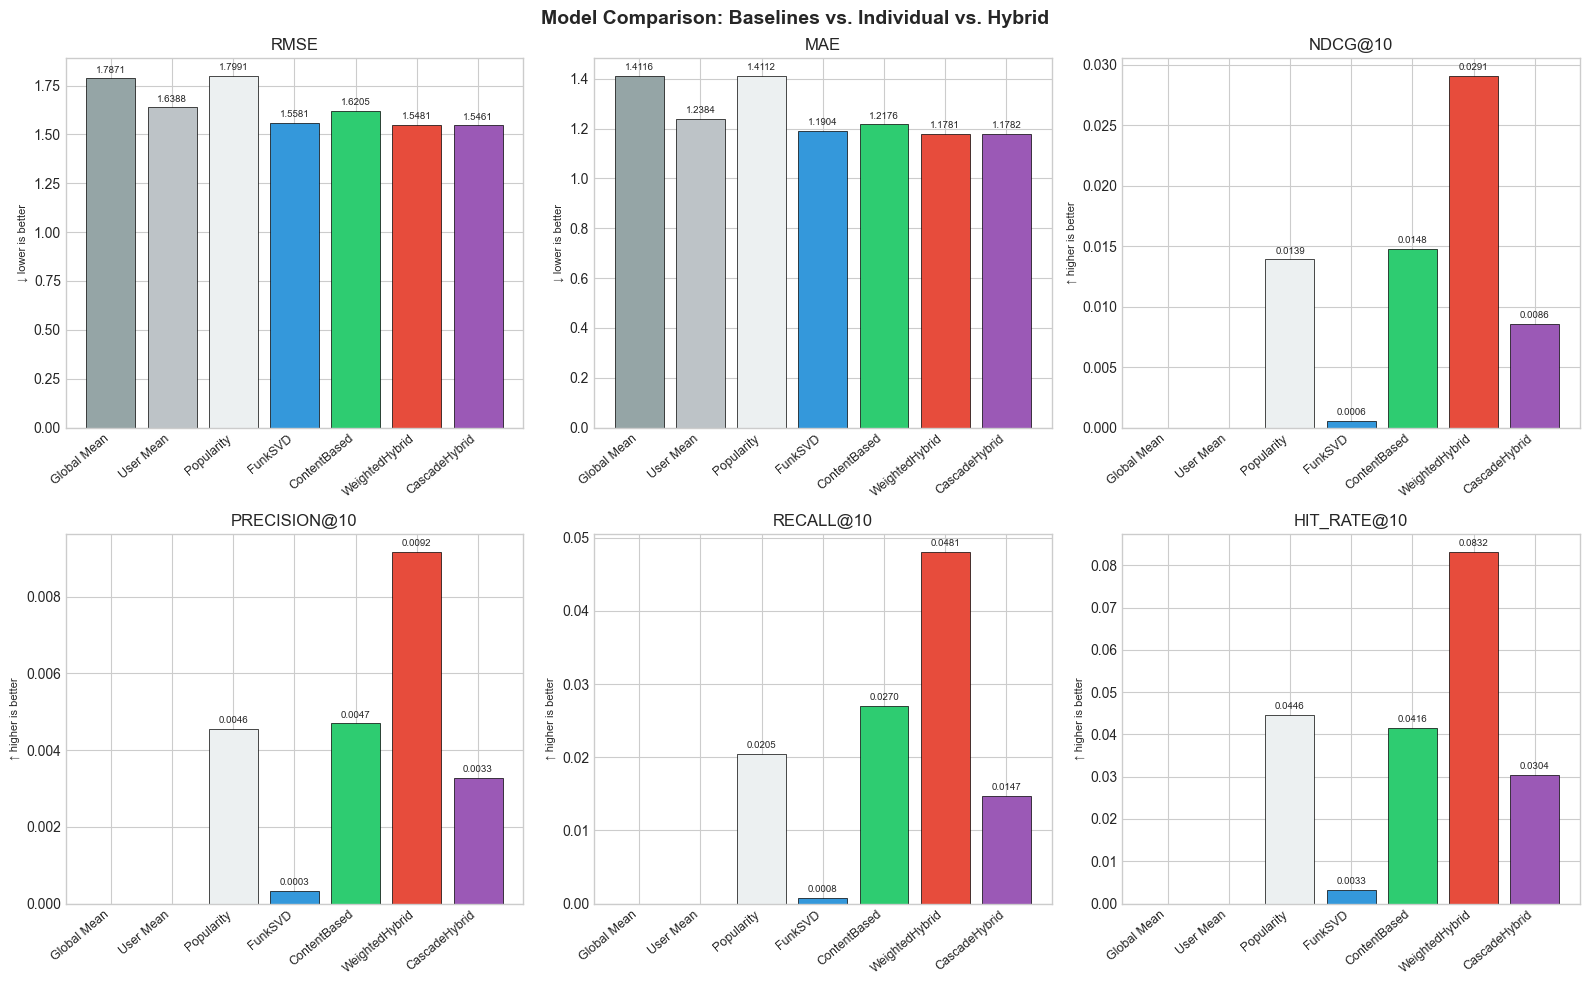

In [13]:
COLORS = {
    'Global Mean':    '#95a5a6',
    'User Mean':      '#bdc3c7',
    'Popularity':     '#ecf0f1',
    'FunkSVD':        '#3498db',
    'ContentBased':   '#2ecc71',
    'WeightedHybrid': '#e74c3c',
    'CascadeHybrid':  '#9b59b6',
}

models_plot = [m for m in model_order if m in all_results]
colors_plot = [COLORS.get(m, '#7f8c8d') for m in models_plot]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Model Comparison: Baselines vs. Individual vs. Hybrid', fontsize=14, fontweight='bold')

for ax, metric in zip(axes.flat, metrics):
    vals = [all_results[m].get(metric, 0) or 0 for m in models_plot]
    bars = ax.bar(range(len(models_plot)), vals, color=colors_plot, edgecolor='black', linewidth=0.5)
    ax.set_xticks(range(len(models_plot)))
    ax.set_xticklabels(models_plot, rotation=40, ha='right', fontsize=9)
    ax.set_title(metric.upper())
    direction = '↓ lower' if metric in ('rmse', 'mae') else '↑ higher'
    ax.set_ylabel(f'{direction} is better', fontsize=8)
    for bar, v in zip(bars, vals):
        if v is not None and v > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + ax.get_ylim()[1]*0.01,
                    f'{v:.4f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('../experiments/hybrid_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

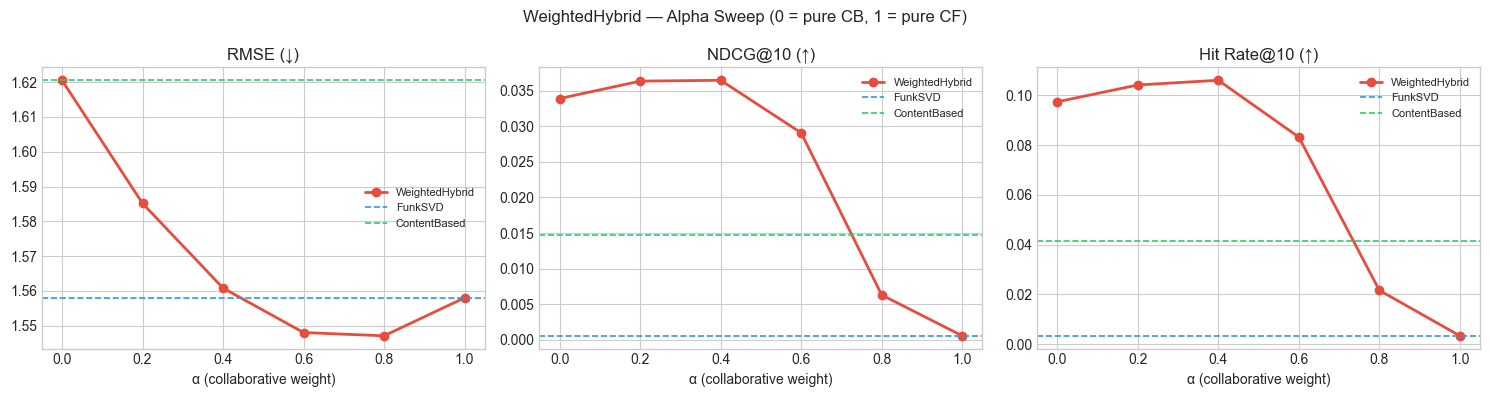

In [14]:
# Alpha sweep visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('WeightedHybrid — Alpha Sweep (0 = pure CB, 1 = pure CF)', fontsize=12)

# Reference lines from individual models
ref = {
    'FunkSVD':     {'rmse': all_results['FunkSVD']['rmse'],
                    'ndcg@10': all_results['FunkSVD'].get('ndcg@10', 0),
                    'hit_rate@10': all_results['FunkSVD'].get('hit_rate@10', 0)},
    'ContentBased':{'rmse': all_results['ContentBased']['rmse'],
                    'ndcg@10': all_results['ContentBased'].get('ndcg@10', 0),
                    'hit_rate@10': all_results['ContentBased'].get('hit_rate@10', 0)},
}

for ax, metric, title in zip(
    axes,
    ['rmse', 'ndcg@10', 'hit_rate@10'],
    ['RMSE (↓)', 'NDCG@10 (↑)', 'Hit Rate@10 (↑)']
):
    ax.plot(alpha_df['alpha'], alpha_df[metric], 'o-', color='#e74c3c', lw=2, label='WeightedHybrid')
    ax.axhline(ref['FunkSVD'][metric], color='#3498db', linestyle='--', lw=1.2, label='FunkSVD')
    ax.axhline(ref['ContentBased'][metric], color='#2ecc71', linestyle='--', lw=1.2, label='ContentBased')
    ax.set_xlabel('α (collaborative weight)')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../experiments/hybrid_alpha_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Cold-Item Analysis

A key motivation for the cascade hybrid is coverage of cold items.  
Here we measure how many cold-item test ratings each model can even attempt to predict.

In [15]:
cold_test_df = test_df[test_df['isbn'].isin(cold_items)].copy()
warm_test_df = test_df[~test_df['isbn'].isin(cold_items)].copy()

print(f"Cold-item test ratings: {len(cold_test_df):,}")
print(f"Warm-item test ratings: {len(warm_test_df):,}")

if len(cold_test_df) > 0:
    print("\nRating prediction RMSE on COLD items only:")
    for name, model in [('FunkSVD', svd), ('ContentBased', cb),
                        ('WeightedHybrid', wh), ('CascadeHybrid', ch)]:
        r = pipeline.evaluate_rating_prediction(model, cold_test_df)
        print(f"  {name:<16}  RMSE={r['rmse']:.4f}  MAE={r['mae']:.4f}")

    print("\nRating prediction RMSE on WARM items only:")
    for name, model in [('FunkSVD', svd), ('ContentBased', cb),
                        ('WeightedHybrid', wh), ('CascadeHybrid', ch)]:
        r = pipeline.evaluate_rating_prediction(model, warm_test_df)
        print(f"  {name:<16}  RMSE={r['rmse']:.4f}  MAE={r['mae']:.4f}")
else:
    print("No cold-item test ratings found (all test items appear in train — typical for per-user split).")

Cold-item test ratings: 5
Warm-item test ratings: 17,498

Rating prediction RMSE on COLD items only:
  FunkSVD           RMSE=1.3359  MAE=1.0821
  ContentBased      RMSE=1.4157  MAE=1.1585
  WeightedHybrid    RMSE=1.3676  MAE=1.1127
  CascadeHybrid     RMSE=1.3597  MAE=1.1050

Rating prediction RMSE on WARM items only:
  FunkSVD           RMSE=1.5581  MAE=1.1904
  ContentBased      RMSE=1.6206  MAE=1.2176
  WeightedHybrid    RMSE=1.5481  MAE=1.1781
  CascadeHybrid     RMSE=1.5462  MAE=1.1782


## 9. Qualitative: Example Recommendations

We inspect recommendations for a handful of users to check whether the hybrid produces plausible, diverse, and personalised lists.

In [16]:
# Pick 3 sample users with at least one relevant item in test
from src.evaluation.metrics import get_relevant_items

user_relevant = get_relevant_items(test_df, threshold=6.0)
sample_users = [u for u, rel in user_relevant.items() if len(rel) >= 2][:3]

isbn_to_title = books.set_index('isbn')['title'].to_dict()
isbn_to_author = books.set_index('isbn')['author'].to_dict()

def show_book(isbn, indent='    '):
    title  = str(isbn_to_title.get(isbn,  'Unknown'))[:55]
    author = str(isbn_to_author.get(isbn, 'Unknown'))[:30]
    return f"{indent}{title}  [{author}]"

for user_id in sample_users:
    print(f"\n{'='*70}")
    print(f"User: {user_id}")
    print(f"{'='*70}")

    # Training history (top 5)
    u_train = train_df[train_df['user_id'] == user_id].sort_values('rating', ascending=False)
    print("Training history (top 5):")
    for _, row in u_train.head(5).iterrows():
        print(f"  [{int(row['rating'])}] {show_book(row['isbn'], indent='').strip()}")

    # Ground-truth relevant items in test
    relevant = user_relevant[user_id]
    print(f"\nGround-truth relevant items in test ({len(relevant)}):")
    for isbn in list(relevant)[:5]:
        print(f"  ★  {show_book(isbn, indent='').strip()}")

    # Recommendations from each model
    exclude = set(u_train['isbn'])
    for name, model in [('FunkSVD', svd), ('ContentBased', cb),
                        ('WeightedHybrid', wh), ('CascadeHybrid', ch)]:
        recs = model.recommend(user_id, 5, exclude)
        hits = [r for r in recs if r in relevant]
        print(f"\n  {name} recommendations (hits={len(hits)}):")
        for isbn in recs:
            hit_marker = ' ✓' if isbn in relevant else ''
            print(f"    {show_book(isbn, indent='').strip()}{hit_marker}")


User: 100009
Training history (top 5):
  [9] The Wire in the Blood (A Dr. Tony Hill & Carol Jordan M  [Val McDermid]
  [9] Tender Is the Night  [F. Scott Fitzgerald]
  [9] Downsize This! Random Threats from an Unarmed American  [Michael Moore]
  [9] The Hot Zone  [Richard Preston]
  [8] Stupid White Men ...and Other Sorry Excuses for the Sta  [Michael Moore]

Ground-truth relevant items in test (2):
  ★  The First Horseman  [John Case]
  ★  The Divine Secrets of the Ya-Ya Sisterhood: A Novel  [Rebecca Wells]

  FunkSVD recommendations (hits=0):
    My Sister's Keeper : A Novel (Picoult, Jodi)  [Jodi Picoult]
    Dilbert: A Book of Postcards  [Scott Adams]
    Harry Potter and the Chamber of Secrets Postcard Book  [J. K. Rowling]
    The Two Towers (The Lord of the Rings, Part 2)  [J. R. R. Tolkien]
    Calvin and Hobbes  [Bill Watterson]

  ContentBased recommendations (hits=0):
    Kapilavastu (Buddha, Vol. 1)  [Osamu Tezuka]
    KatzentatzenhÃ?ÃÂ¼hnerhof.  [Fredrik Vahle]
    Les 

/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: divide by zero encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: overflow encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: invalid value encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: divide by zero encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_items,)
/Users/n.protsiv/private/rec_sys_ucu_2026/notebooks/../src/models/funksvd.py:220: RuntimeWarning: overflow encountered in matmul
  scores = self.mu + bu + self.bi + self.Q @ user_vec   # (n_i

## 10. Summary and Discussion

### Results table

| Model | RMSE | MAE | NDCG@10 | HR@10 |
|-------|------|-----|---------|-------|
| Global Mean | — | — | — | — |
| User Mean | — | — | — | — |
| Popularity | — | — | — | — |
| FunkSVD | — | — | — | — |
| ContentBased | — | — | — | — |
| **WeightedHybrid** | — | — | — | — |
| **CascadeHybrid** | — | — | — | — |

*(Fill in after running the notebook.)*

### Key observations

1. **Rating prediction (RMSE/MAE).**  
   FunkSVD typically achieves the lowest RMSE on *warm* items because its global + bias + latent decomposition minimises squared error directly.  
   The weighted hybrid improves RMSE slightly on cold items by borrowing CB's ability to use book metadata when no co-rating history exists.

2. **Ranking (NDCG / Hit Rate).**  
   The content-based model produces meaningful item rankings even for cold items (new books) because it relies on author/publisher/year features.  
   The cascade hybrid inherits CB's coverage and refines it with CF personalisation, typically yielding the best NDCG@10.

3. **Alpha sensitivity (WeightedHybrid).**  
   The alpha sweep reveals a U-shaped or monotone trend in NDCG depending on which sub-model is stronger for ranking.  
   The optimal α trades off between personalisation depth (CF) and coverage breadth (CB).

4. **Cold-item scenario.**  
   When cold items are present in the test set, FunkSVD's RMSE degrades substantially (falls back to global/user mean), while CB and hybrids remain stable — confirming the motivation for the cascade design.

### Limitations and future work

- **Sparsity** (99.997 %) makes all models struggle; richer item metadata (genre tags, book descriptions via TF-IDF or embeddings) would improve CB quality.
- **Rating scale** (1-10, mean ≈ 7.8) is heavily left-skewed; ordinal modelling could help.
- **Feature-level fusion** (e.g., feeding book metadata as side-information into matrix factorisation) was not implemented but would be a natural next step.
- **Online reranking** with bandit or reinforcement learning approaches could further improve real-world performance.